<a href="https://colab.research.google.com/github/miczkejedrzej/MNLP-project-1/blob/main/Data_collection_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import of the training data

from google.colab import files
uploaded = files.upload()

# Import of moduls

!pip install wikidata --quiet

import matplotlib.pyplot as plt
import pandas as pd
from wikidata.client import Client
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

from tqdm.auto import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Loading the data
train_df = pd.read_csv('[MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv', sep='\t')

Saving [MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv to [MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv


In [24]:
!pip install datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda

In [25]:
from datasets import load_dataset
from huggingface_hub import login

# First : Create an account on Hugging face, and create also a token

# Connection to hugging face
#login(token="")

dataset = load_dataset('sapienzanlp/nlp2025_hw1_cultural_dataset')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/946k [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/45.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6251 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/300 [00:00<?, ? examples/s]

In [26]:
dev_df = dataset['validation'].to_pandas()

In [4]:
# Installation de spaCy et du modèle pré-entraîné Word2Vec
!pip install spacy --quiet
#!python -m spacy download en_vectors_web_lg --quiet
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 39.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# en_core_web_md : example of use

In [5]:
import spacy

# Loading the pretrained model
nlp = spacy.load("en_core_web_md")

In [12]:
# Get the description of an item, and see what en_core_web_md does to it
test_description = train_df['description'][0]
doc = nlp(test_description)

doc

'Chilean entrepreneur and politician (1949–2024)'

In [29]:
test_description = train_df['description'][0]
doc = nlp(test_description)

# Affiche le texte complet analysé par spaCy
print("Texte complet : ", doc)

# Affiche chaque mot (token) avec :
# - POS (Part Of Speech) : catégorie grammaticale (ex: NOUN, VERB, etc.)
# - Lemma : forme de base du mot (ex: "running" -> "run")
# - Dép : rôle grammatical du mot dans la phrase (ex: sujet, complément, etc.)
print("\nAnalyse des tokens (mots) :")
for token in doc:
    print(f"{token.text} -> POS: {token.pos_}, Lemma: {token.lemma_}, Dép: {token.dep_}")

# Affiche les entités nommées reconnues dans le texte :
# - ent.text : texte de l'entité
# - ent.label_ : type d'entité (ex: PERSON, GPE = pays/ville, ORG = organisation, DATE, etc.)
print("\nEntités nommées reconnues :")
for ent in doc.ents:
    print(f"{ent.text} ({ent.label_})")

# Affiche le vecteur moyen du texte (représentation numérique globale de la phrase)
# Ce vecteur est utilisé dans ton modèle KNN pour comparer des textes entre eux
print("\nVecteur moyen du texte :")
print(doc.vector)

# Affiche le nombre de tokens dans le texte (mots + ponctuation)
print("\nNombre de tokens dans le texte :", len(doc))

Texte complet :  Chilean entrepreneur and politician (1949–2024)

Analyse des tokens (mots) :
Chilean -> POS: ADJ, Lemma: chilean, Dép: amod
entrepreneur -> POS: NOUN, Lemma: entrepreneur, Dép: ROOT
and -> POS: CCONJ, Lemma: and, Dép: cc
politician -> POS: NOUN, Lemma: politician, Dép: conj
( -> POS: PUNCT, Lemma: (, Dép: punct
1949–2024 -> POS: NUM, Lemma: 1949–2024, Dép: appos
) -> POS: PUNCT, Lemma: ), Dép: punct

Entités nommées reconnues :
Chilean (NORP)
1949–2024 (DATE)

Vecteur moyen du texte :
[-6.45932853e-01  1.40171722e-01  5.24281487e-02 -7.14885723e-03
  1.31865684e-02 -9.28508416e-02  1.17651276e-01 -1.67057291e-01
  1.32029997e-02  1.22803223e+00 -3.55498552e-01  6.53858704e-04
 -2.43865415e-01 -2.42960025e-02 -6.32285699e-02 -4.78675701e-02
 -1.94174007e-01  8.18849981e-01 -1.03820004e-01 -1.63105689e-02
 -1.12887202e-02 -4.59328555e-02 -1.31904289e-01 -1.89761743e-01
  7.68997148e-02 -2.21957296e-01 -4.09878492e-02  9.08924267e-02
  2.41685718e-01  1.76607579e-01  9.67

In [30]:
token = doc[3]
print(dir(token))  # liste toutes les propriétés et méthodes disponibles

['_', '__bytes__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__unicode__', 'ancestors', 'check_flag', 'children', 'cluster', 'conjuncts', 'dep', 'dep_', 'doc', 'ent_id', 'ent_id_', 'ent_iob', 'ent_iob_', 'ent_kb_id', 'ent_kb_id_', 'ent_type', 'ent_type_', 'get_extension', 'has_dep', 'has_extension', 'has_head', 'has_morph', 'has_vector', 'head', 'i', 'idx', 'iob_strings', 'is_alpha', 'is_ancestor', 'is_ascii', 'is_bracket', 'is_currency', 'is_digit', 'is_left_punct', 'is_lower', 'is_oov', 'is_punct', 'is_quote', 'is_right_punct', 'is_sent_end', 'is_sent_start', 'is_space', 'is_stop', 'is_title', 'is_upper', 'lang', 'lang_', 'left_edge', 'lefts', 'lemma', 'lemma_', 'lex', 'lex_id', 'li

# KNN

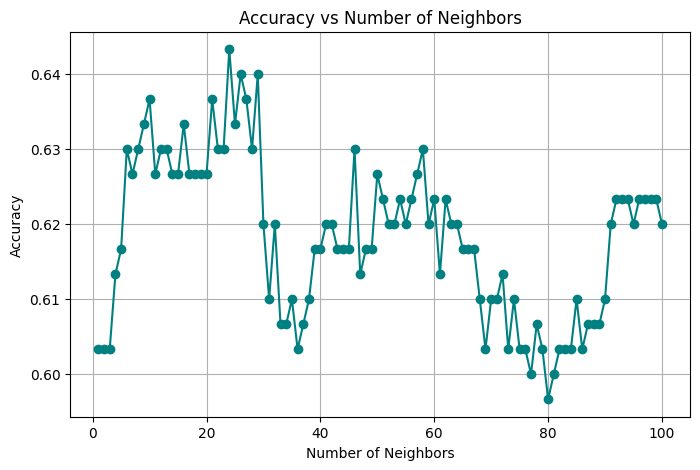

<Figure size 640x480 with 0 Axes>

In [37]:
# Exctract the texte and the label : Training
train_texts = train_df['description'].to_list()
train_labels = train_df['label'].to_list()

# Exctract the texte and the label : Dev
dev_texts = dev_df['description'].to_list()
dev_labels = dev_df['label'].to_list()

# Vectorize the texts with en_core_web_md
train_vectors = np.array([nlp(text).vector for text in train_texts])
dev_vectors = np.array([nlp(text).vector for text in dev_texts])

accuracies = {}

# We test many values of k (number of neighbors in KNN)
for k in range(1, 101):
    knn = NearestNeighbors(n_neighbors=k, metric='cosine')
    knn.fit(train_vectors)

    predicted_labels = []

    for vec in vectors_dev:
        distances, indices = knn.kneighbors(vec.reshape(1, -1))

        # Get the k closest labels
        neighbor_labels = [train_labels[idx] for idx in indices[0]]

        # Choose the label (the most frequent one)
        label_counts = {}
        for label in neighbor_labels:
            label_counts[label] = label_counts.get(label, 0) + 1
        majority_label = max(label_counts.items(), key=lambda x: x[1])[0]

        predicted_labels.append(majority_label)

    # Compute accuracy
    accuracy = accuracy_score(dev_labels, predicted_labels)
    accuracies[k] = accuracy

# Plot Accuracy vs Number of Neighbors
plt.figure(figsize=(8, 5))
plt.plot(list(accuracies.keys()), list(accuracies.values()), marker='o', color='teal')
plt.title("Accuracy vs Number of Neighbors")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()
plt.savefig('Accuracy_vs_Neighbors')

In [46]:
# We get the best k : the one that gives the best accuracy
best_k = max(accuracies, key=accuracies.get)

# We train the final model, with best_k
knn = NearestNeighbors(n_neighbors=best_k, metric='cosine')
knn.fit(vectors_train)

# We predict the labels for each item of the dev set
final_predicted_labels = []
for vec in vectors_dev:
    distances, indices = knn.kneighbors(vec.reshape(1, -1))
    neighbor_labels = [labels_train[idx] for idx in indices[0]]
    majority_label = max(set(neighbor_labels), key=neighbor_labels.count)
    final_predicted_labels.append(majority_label)

dev_df['predicted_label_KNN'] = final_predicted_labels

In [48]:
dev_df.head()

,item,name,description,type,category,subcategory,label,predicted_label_KNN
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,cultural representative,cultural exclusive
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,cultural exclusive,cultural exclusive
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,cultural representative,cultural representative
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,cultural exclusive,cultural representative
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,cultural representative,cultural representative


In [49]:
dev_df['predicted_label_KNN'].value_counts()

,count
predicted_label_KNN,
cultural agnostic,148
cultural exclusive,103
cultural representative,49


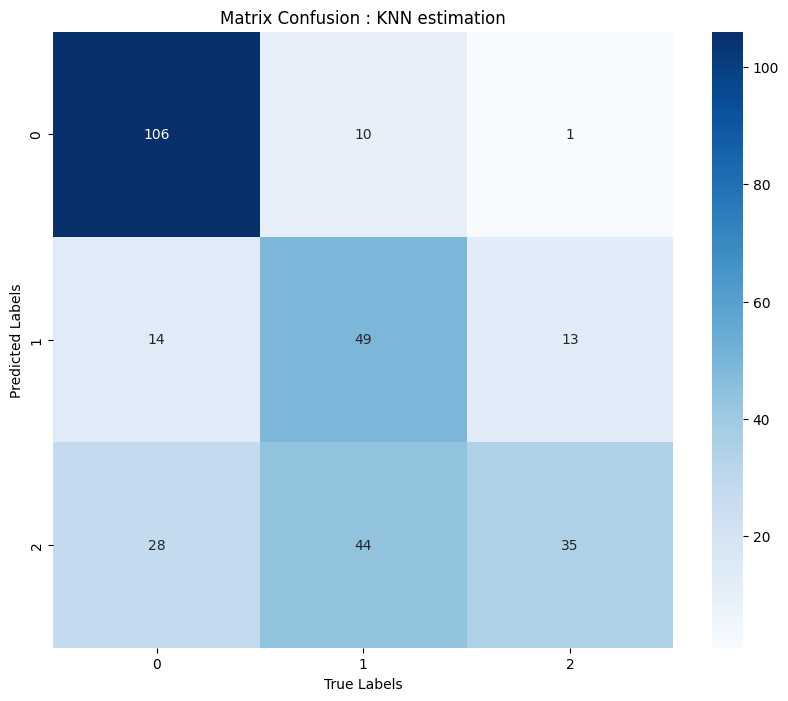

In [62]:
# Creation of the confusion matrix
y_true = dev_df['label']
y_pred = dev_df['predicted_label_KNN']
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Matrix Confusion : KNN estimation')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()